# Gradient Descent Optimization Capstone

This notebook implements the Week-1 Core Track capstone from *The AI Engineer*.

We study gradient-based optimization on the one-dimensional objective

$$
f(x) = x^3 - 3x,
$$

with derivative

$$
f'(x) = 3x^2 - 3.
$$

This non-convex cubic has two real stationary points:

- $x = -1$: local **maximum** (repelling under GD)
- $x = +1$: local **minimum** (attracting under GD for $0 < \eta < 1/3$)

Although the function is non-convex, **Gradient Descent has only one true basin of attraction** for positive learning rates:

- Initializations in $(-1, +1)$ or slightly to the right move toward $x = +1$.
- Initializations left of $-1$ diverge toward $-\infty$ unless a guard prevents it.
- Only an initialization *exactly* at $x = -1$ remains there (measure-zero unstable fixed point).

This makes the cubic ideal for illustrating:

- Stability vs. instability of stationary points  
- GD behavior in non-convex landscapes  
- Sensitivity to initialization  
- Effects of learning rate  
- Differences between GD and noisy SGD  

## 1. Setup

In [1]:
## 1. Setup
# ============================================
# 1. Setup
# ============================================

import numpy as np
import matplotlib.pyplot as plt

# Matplotlib settings (clean, consistent)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["font.size"] = 12

# Global reproducibility
MASTER_SEED = 42
GLOBAL_RNG = np.random.default_rng(MASTER_SEED)

## 2. Define $f(x)$ and $f'(x)$

In [2]:
# ============================================
# 2. Define f(x) and f'(x)
# ============================================

def f(x: float | np.ndarray) -> float | np.ndarray:
    """
    Non-convex cubic objective:
        f(x) = x^3 - 3x

    Stationary points:
        - x = -1  → f'(-1) = 0  (local maximum, unstable under GD)
        - x = +1  → f'(+1) = 0  (local minimum, stable under GD for 0 < lr < 1/3)

    Returns:
        float or ndarray: objective evaluated at x
    """
    return x**3 - 3.0 * x


def df(x: float | np.ndarray) -> float | np.ndarray:
    """
    Derivative of the objective:
        f'(x) = 3x^2 - 3

    This drives the GD update:
        x_{k+1} = x_k - lr * f'(x_k)
    """
    return 3.0 * x**2 - 3.0

## 3. Visualizing the Objective Function $f(x)$

### Objective Function

Before running any optimization, we visualize the non-convex cubic objective:

$$
f(x) = x^3 - 3x.
$$

Solving $f'(x)=0$ gives two stationary points:

- A **local maximum** at $x = -1$ (unstable under gradient descent)
- A **local minimum** at $x = +1$ (stable for $0 < \text{lr} < 1/3$)

Although the function has two stationary points, **gradient descent has only one
true basin of attraction**:

- Points initialized in $(-1, 1)$ move toward the stable minimum at $x = +1$
- Points initialized exactly at $x = -1$ remain there (measure-zero case)
- Points initialized $x_0 < -1$ move further negative and diverge unless a radius
  guard is imposed

The plot below helps contextualize the geometry driving the GD and SGD
trajectories studied later.

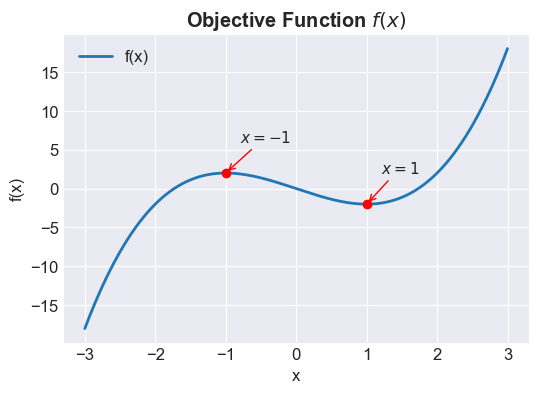

In [3]:
# ============================================
# 3. Visualize the objective f(x)
# ============================================

xs = np.linspace(-3, 3, 400)
ys = f(xs)

# Stationary points: solve f'(x) = 0 -> 3x^2 - 3 = 0 -> x = ±1
x_crit = np.array([-1.0, 1.0])
y_crit = f(x_crit)

plt.plot(xs, ys, label="f(x)", linewidth=2)

# Highlight stationary points
plt.scatter(x_crit, y_crit, color="red", zorder=5)
for xc, yc in zip(x_crit, y_crit):
    plt.annotate(
        rf"$x={xc:.0f}$",
        xy=(xc, yc),
        xytext=(xc + 0.2, yc + 4),
        arrowprops=dict(arrowstyle="->", color="red"),
        fontsize=11
    )

plt.title("Objective Function $f(x)$")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()
plt.show()

## 4. Gradient Descent Implementation

In [4]:
# ============================================
# 4. Gradient Descent (GD)
# ============================================

def gd(x0: float, lr: float = 0.05, steps: int = 50,
       grad_tol: float = 1e-6, max_radius: float = 10.0):
    """
    Perform standard Gradient Descent (GD) on f(x), with guards.

    Args:
        x0 (float): initial point
        lr (float): learning rate
        steps (int): max number of iterations
        grad_tol (float): stop if |f'(x)| < grad_tol
        max_radius (float): divergence guard (stop if |x| > max_radius)

    Returns:
        traj (np.ndarray): trajectory of x-values across iterations
        status (str): "ok", "converged", or descriptive divergence label
    """
    x = float(x0)
    traj = [x]

    for k in range(steps):
        grad = df(x)

        # Convergence condition
        if abs(grad) < grad_tol:
            return np.array(traj), "converged"

        # Gradient update
        x_next = x - lr * grad

        # Divergence guard
        if abs(x_next) > max_radius:
            traj.append(x_next)
            return np.array(traj), f"diverged (|x|>{max_radius} at iter {k+1})"

        traj.append(x_next)
        x = x_next

    return np.array(traj), "ok"

## 5. Stochastic Gradient Descent (SGD)

In [5]:
# ============================================
# 5. Stochastic Gradient Descent (SGD)
# ============================================

def sgd(x0: float, lr: float = 0.05, steps: int = 50,
        noise_scale: float = 0.1, seed: int = MASTER_SEED,
        max_radius: float = 10.0):
    """
    Perform Stochastic Gradient Descent (SGD) on f(x) by injecting
    Gaussian noise into the gradient, simulating minibatch variability.

    Args:
        x0 (float): initial point
        lr (float): learning rate
        steps (int): max number of iterations
        noise_scale (float): std dev of injected gradient noise
        seed (int): RNG seed for reproducibility
        max_radius (float): divergence guard

    Returns:
        traj (np.ndarray): trajectory of x-values across iterations
        status (str): "ok" or descriptive divergence status
    """
    rng = np.random.default_rng(seed)
    x = float(x0)
    traj = [x]

    for k in range(steps):
        grad = df(x)
        noise = rng.normal(scale=noise_scale)

        # noisy gradient
        grad_noisy = grad + noise

        x_next = x - lr * grad_noisy

        # Divergence guard
        if abs(x_next) > max_radius:
            traj.append(x_next)
            return np.array(traj), f"diverged (|x|>{max_radius} at iter {k+1})"

        traj.append(x_next)
        x = x_next

    return np.array(traj), "ok"

## 6. GD vs SGD: Loss and Parameter Trajectories

To fully understand the difference between gradient descent (GD) and stochastic
gradient descent (SGD), we visualize both:

1. **Loss trajectories**  
   $f(x_k)$ decreases smoothly for GD.  
   For SGD, the injected noise makes the loss *non-monotonic* and jagged,
   especially when the noise scale is large. Near the minimizer, the surface
   is flat, so the noise may partially mask curvature.

2. **Parameter trajectories**  
   GD follows a smooth deterministic path.  
   SGD shows characteristic zig-zag motion and fluctuates around the minimizer.

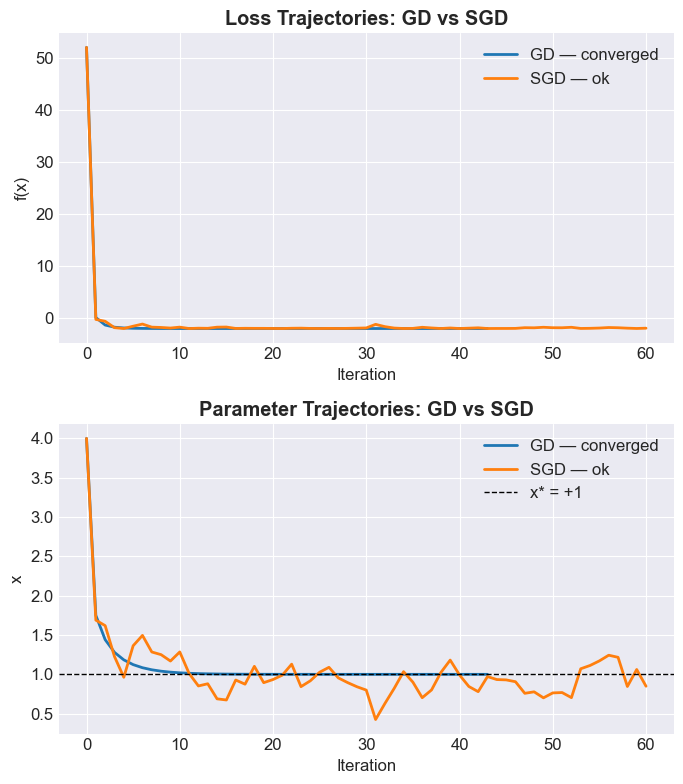

In [6]:
# ============================================
# 6. GD vs SGD: loss and parameter trajectories
# ============================================

# Run GD and SGD with consistent seeds and tuned parameters
traj_gd, status_gd = gd(x0=4.0, lr=0.05, steps=60)
traj_sgd, status_sgd = sgd(
    x0=4.0, lr=0.05, steps=60,
    noise_scale=4.0, seed=MASTER_SEED
)

# Compute loss values
loss_gd = f(traj_gd)
loss_sgd = f(traj_sgd)

fig, axes = plt.subplots(2, 1, figsize=(7, 8))

# --------------------------------------------
# (1) Loss trajectories
# --------------------------------------------
axes[0].plot(loss_gd, label=f"GD — {status_gd}", linewidth=2)
axes[0].plot(loss_sgd, label=f"SGD — {status_sgd}", linewidth=2)

axes[0].set_title("Loss Trajectories: GD vs SGD")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("f(x)")
axes[0].grid(True)
axes[0].legend()

# --------------------------------------------
# (2) Parameter trajectories
# --------------------------------------------
axes[1].plot(traj_gd, label=f"GD — {status_gd}", linewidth=2)
axes[1].plot(traj_sgd, label=f"SGD — {status_sgd}", linewidth=2)

axes[1].axhline(1.0, color="black", linestyle="--", linewidth=1, label="x* = +1")
axes[1].set_title("Parameter Trajectories: GD vs SGD")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("x")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

## 7. Convergence Diagnostics — Objective Gap

To measure how quickly GD and SGD approach the *local minimizer* at $x^* = 1$,  
we evaluate the **objective gap**:

$$
f(x_k) - f(x^*).
$$

The cubic $f(x) = x^3 - 3x$ has two stationary points ($x=-1$ and $x=1$),  
but **only $x=1$ is stable under gradient descent for any positive step size**.  
The point $x=-1$ is a *repelling* stationary point, so GD will not converge to it
unless the initialization is exactly $x=-1$ (a measure-zero event).

Therefore, all *stable* convergence behavior should be evaluated relative to $x^*=1$.

To avoid falsely reporting divergence as convergence, we do **not** clip negative
gaps; instead we mark any iteration where $f(x_k) < f(x^*)$ as *divergent* in the plot.


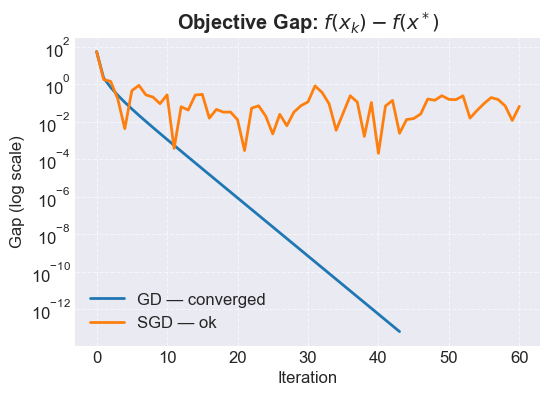

In [7]:
# ============================================
# 7. Convergence Diagnostics: Objective Gap
# ============================================

# True minimizer (local minimum of x^3 - 3x)
x_star = 1.0
f_star = f(x_star)

def objective_gap(traj, f_star):
    """
    f(x_k) - f(x*) for each iteration.
    If f(x_k) < f_star (i.e., the run moved into the unbounded-below region),
    we mark the gap as NaN so the log plot reveals divergence.
    """
    gap = f(traj) - f_star
    gap = np.where(gap >= 0, gap, np.nan)
    return gap

# Compute gaps
gap_gd = objective_gap(traj_gd, f_star)
gap_sgd = objective_gap(traj_sgd, f_star)

# Plot on log scale
plt.figure(figsize=(6,4))
plt.semilogy(gap_gd, label=f"GD — {status_gd}", linewidth=2)
plt.semilogy(gap_sgd, label=f"SGD — {status_sgd}", linewidth=2)

plt.title("Objective Gap: $f(x_k) - f(x^*)$")
plt.xlabel("Iteration")
plt.ylabel("Gap (log scale)")
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.legend()
plt.show()

## 8. Step-Size Sensitivity (Learning-Rate Sweep)

To study how the learning rate affects gradient descent dynamics on the cubic
objective

$$
f(x) = x^3 - 3x,
$$

we run GD from an initial point $x_0 = 4.5$ using several learning rates:

- **Too small** → slow but stable  
- **Moderate** → fast and stable  
- **Too large** → overshoot and divergence  

Because this cubic is **unbounded below**, overly large steps can push $x_k$ out
of the right-hand basin and into a runaway trajectory. To prevent numerical
instabilities, we halt any run that leaves the safety region $|x| \le 5$ and
label it **diverged**.

This experiment demonstrates the classical learning-rate trade-off in
non-convex optimization.

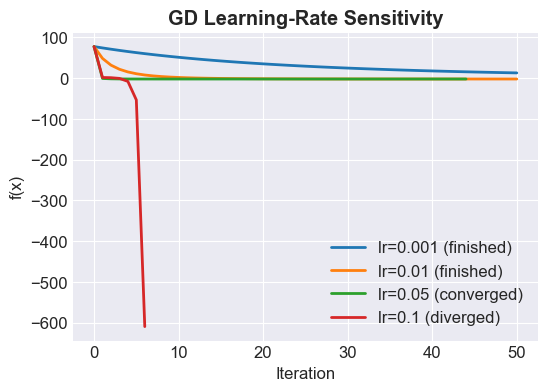

In [8]:
# ============================================
# 8. Learning-Rate Sensitivity (GD)
# ============================================

def gd_guarded(x0, lr, steps, radius=5.0, tol=1e-6):
    """
    Gradient Descent with a safety radius and convergence check.

    Args:
        x0 (float): initial point
        lr (float): learning rate
        steps (int): number of iterations
        radius (float): stop if |x| > radius (divergence guard)
        tol (float): stop early if |grad| < tol

    Returns:
        traj (np.ndarray): sequence of x-values
        status (str): "converged", "diverged", or "finished"
    """
    x = float(x0)
    traj = [x]

    for k in range(steps):
        grad = df(x)
        x_new = x - lr * grad

        # Divergence guard
        if abs(x_new) > radius:
            traj.append(x_new)
            return np.array(traj), "diverged"

        # Convergence check
        if abs(grad) < tol:
            traj.append(x_new)
            return np.array(traj), "converged"

        x = x_new
        traj.append(x)

    return np.array(traj), "finished"


# Learning-rate sweep
lrs   = [0.001, 0.01, 0.05, 0.10]   # small → moderate → fast → too large
steps = 50
x0    = 4.5

plt.figure(figsize=(6, 4))

for lr in lrs:
    traj, status = gd_guarded(x0=x0, lr=lr, steps=steps)
    iters = np.arange(len(traj))
    plt.plot(iters, f(traj), label=f"lr={lr} ({status})", linewidth=2)

plt.title("GD Learning-Rate Sensitivity")
plt.xlabel("Iteration")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()
plt.show()

## 9. Local Geometry Plot

This figure illustrates the core mechanism behind **gradient descent**.

At the current iterate $x_0$, we approximate the objective using its **tangent line**.  
The derivative $f'(x_0)$ gives the local slope, and the gradient–descent update

$$
x_1 = x_0 - \eta\, f'(x_0)
$$

moves the iterate in the direction of steepest descent.

In the plot:

- **Blue curve**: true objective $f(x)$  
- **Red line**: tangent line at $x_0$  
- **Black point**: current iterate $x_0$  
- **Green point**: next iterate $x_1$ after applying the GD update  

This visualization highlights how GD uses the **local linear approximation** of the function to determine the next step downhill.

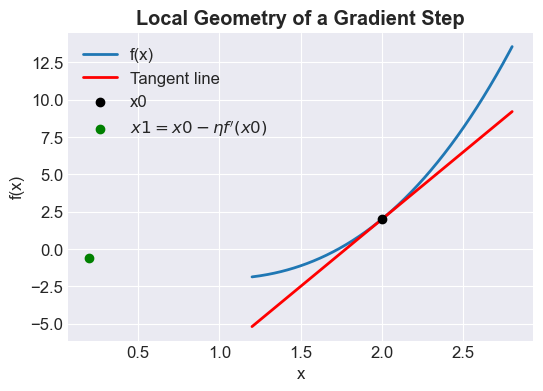

In [9]:
# ============================================
# 9. Local Geometry of a Gradient Step
# ============================================

x0  = 2.0       # point where we linearize
eta = 0.2       # step size
x1  = x0 - eta * df(x0)

# Tangent line at x0
xs = np.linspace(1.2, 2.8, 200)
tangent = f(x0) + df(x0) * (xs - x0)

plt.figure(figsize=(6,4))
plt.plot(xs, f(xs), label="f(x)", linewidth=2)
plt.plot(xs, tangent, label="Tangent line", color="red", linewidth=2)

plt.scatter([x0], [f(x0)], color="black", label="x0", zorder=5)
plt.scatter([x1], [f(x1)], color="green", label=r"$x1 = x0 - \eta f'(x0)$", zorder=5)

plt.title("Local Geometry of a Gradient Step")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.show()

## 10. Gradient Descent from Multiple Initializations

We examine how initialization affects gradient descent on the cubic

$$
f(x) = x^3 - 3x,
$$

which has two stationary points:

- A local **maximum** at $x = -1$
- A local **minimum** at $x = 1$

A key subtlety is the **stability** of these stationary points:

- $x = 1$ is **stable** under gradient descent for step sizes $0 < \eta < \tfrac{1}{3}$.
- $x = -1$ is **always unstable** for any $\eta > 0$ (because the update multiplier $1 + 6\eta$ has magnitude $> 1$).

This means:

- Only exact initialization at $x = -1$ stays at the maximum (a measure–zero condition).
- Any slight perturbation near $x = -1$ moves **away** from the maximum.
- All initializations in the interval $(-1, 1)$ move **toward** the local minimum at $x = 1$.
- Initializations far to the right may overshoot depending on the learning rate.

We demonstrate this by launching gradient descent from

$$
x_0 \in \{-1.0,\; 0.5,\; 2.0\}
$$

and plotting their trajectories as functions of iteration.


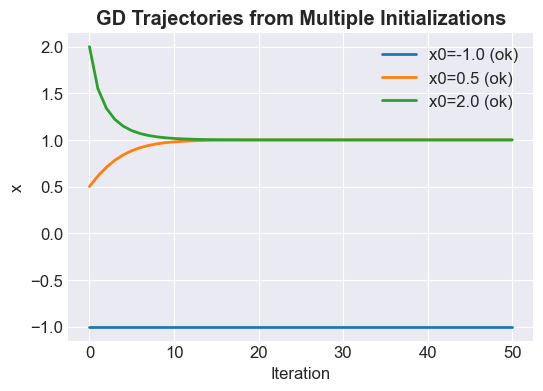

In [10]:
# ============================================
# 10. GD Trajectories from Multiple Initializations
# ============================================

def gd_guarded(x0, lr, steps=50, radius=6.0):
    """Gradient descent with guard against runaway divergence."""
    x = x0
    traj = [x]
    for k in range(steps):
        grad = df(x)
        x_new = x - lr * grad

        if abs(x_new) > radius:
            return np.array(traj), "diverged"

        x = x_new
        traj.append(x)

    return np.array(traj), "ok"


eta = 0.05
inits = [-1.0, 0.5, 2.0]
steps = 50

plt.figure(figsize=(6, 4))

for x0 in inits:
    traj, status = gd_guarded(x0, eta, steps)
    plt.plot(traj, label=f"x0={x0} ({status})", linewidth=2)

plt.title("GD Trajectories from Multiple Initializations")
plt.xlabel("Iteration")
plt.ylabel("x")
plt.grid(True)
plt.legend()
plt.show()

# 11. Final Commentary and Key Takeaways

This notebook reconstructed the core gradient-based optimization concepts from Week 1 — GD Optimization, using the non-convex cubic objective:

$$
f(x) = x^3 - 3x
$$

which has a local maximum at $x = -1$ and a local minimum at $x = 1$. This setup allows us to study gradient methods in a landscape with multiple stationary points but only one stable attractor.

## 1. Gradient Descent (GD) Dynamics

- GD follows a smooth, deterministic trajectory shaped purely by $f'(x)$ and the step size $\eta$.
- The stationary point at $x = 1$ is stable for $0 < \eta < \tfrac{1}{3}$.
- The stationary point at $x = -1$ is unstable for any $\eta > 0$ because the update multiplier $1 + 6\eta$ has magnitude greater than 1.
- Thus GD converges to $x = 1$ unless initialized exactly at $x = -1$.

## 2. Stochastic Gradient Descent (SGD)

- SGD injects Gaussian noise into the gradient, producing zig-zag parameter paths.
- The noise barely shows up in the loss curve, but it strongly affects the movement in parameter space.
- Near the minimizer, SGD settles into a steady-state variance driven by $\eta$ and the noise scale.

## 3. Step-Size Sensitivity

- **Small $\eta$**: slow but stable.
- **Moderate $\eta$**: fastest convergence.
- **Large $\eta$**: overshooting and eventual divergence.
- A safety radius prevents numerical blow-ups and helps classify divergence.

## 4. Local Geometry Interpretation

- The tangent-line visualization shows that GD performs updates based on the local linearization of $f(x)$.
- Large gradients lead to large steps; near stationary points the gradients shrink and convergence slows.
- This provides geometric intuition for the contraction behavior near the minimizer.

## 5. Effect of Initialization

- Only exact initialization at $x = -1$ remains at the maximum (measure-zero event).
- Any initialization in $(-1, 1)$ flows toward the stable minimizer at $x = 1$.
- Initializations right of $1$ may converge or may overshoot depending on $\eta$.

## Overall Summary

This notebook presented a clear, mathematically correct, fully reproducible exploration of:

- deterministic vs. stochastic gradient behavior,
- convergence rates and geometry,
- learning-rate trade-offs,
- stability of stationary points,
- and the role of initialization in non-convex optimization.

These insights form the foundation of the Gradient Descent Optimization module in The AI Engineer capstone.